In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AIFFEL

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AIFFEL


In [2]:
!mkdir -p ./work/sentiment_classification

# 실습에 활용할 수 있도록 라이브러리 설치 및 다운그레이드를 수행합니다
!pip install gensim==4.3.2
!pip install scipy==1.12.0 numpy==1.26.3

# 프로젝트 노드 - 네이버 영화리뷰 감성분석 도전하기

In [3]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
!mv ratings_*.txt ./work/sentiment_classification/data

--2025-10-27 22:30:36--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt.1’

ratings_train.txt.1 100%[===================>]  13.95M  17.0MB/s    in 0.8s    

2025-10-27 22:30:37 (17.0 MB/s) - ‘ratings_train.txt.1’ saved [14628807/14628807]

--2025-10-27 22:30:37--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [application/o

In [4]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 6.25 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/drive/MyDrive/AIFFEL/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-10-27 22:31:40--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.143.21, 104.192.143.22, 104.192.143.23, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.143.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?respo

In [5]:
!python --version

Python 3.12.12


In [6]:
!pip install gensim==4.3.2

In [7]:
# 의존성 연결을 위해 다운그레이드를 진행합니다.
!pip install scipy==1.12.0 numpy==1.26.3

In [8]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.2.2
0.6.0
4.3.2


## 데이터 준비와 확인

In [10]:
import pandas as pd
import os

# 데이터를 읽어봅시다.
%cd /content/drive/MyDrive/AIFFEL
train_data = pd.read_table('./' + 'work/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('./' + 'work/sentiment_classification/data/ratings_test.txt')

train_data.head()

/content/drive/MyDrive/AIFFEL


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

In [27]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [28]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [40]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

In [32]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[32, 74, 939, 4, 4, 39, 229, 20, 33, 747]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [33]:
print(index_to_word)     # 'the' 가 출력됩니다.
print(word_to_index)  # 1 이 출력됩니다.

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '로', 29: '정말', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '어', 35: '재밌', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '기', 42: '에서', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '인', 53: '연기', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '해', 66: '1', 67: '스토리', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '아니', 73: '생각', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '보다', 87: '알', 88: '만들', 89: '내용', 90: '볼', 91: '감독', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '못', 105:

In [34]:
# 보정 전 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

더 빙 . . 진짜 짜증 나 네요 목소리


In [35]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [36]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.971024731364448
문장길이 최대 :  116
문장길이 표준편차 :  12.84408055468762
pad_sequences maxlen :  41
전체 문장의 0.9342629991962691%가 maxlen 설정값 이내에 포함됩니다. 


In [46]:
import torch
import torch.nn as nn
import numpy as np
import os

def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)

x_train_padded = pad_sequences(x_train, maxlen)
x_test_padded = pad_sequences(x_test, maxlen)

x_train_tensor = torch.tensor(x_train_padded, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)
print(x_train_tensor.shape)

torch.Size([146182, 41])


In [41]:
vocab_size = len(word_to_index)   # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4   # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = nn.Embedding(vocab_size, word_vector_dim, padding_idx=word_to_index['<PAD>'])

# nn.Embedding를 통해 word vector를 모두 일정 길이로 맞춰주어야
# embedding 레이어의 input이 될 수 있음에 주의해 주세요.
encoded_sentences = get_encoded_sentences(x_train, word_to_index)
padded_sentences = [sentence + [word_to_index['<PAD>']] * (maxlen - len(sentence)) if len(sentence) < maxlen else sentence[:maxlen] for sentence in encoded_sentences]

raw_inputs = torch.tensor(padded_sentences, dtype=torch.long)
output = embedding(raw_inputs)

In [58]:
# (train, val, test 모두 같은 방식으로 처리)
encoded_sentences_test = get_encoded_sentences(x_test, word_to_index)

padded_sentences_test = [
    sentence + [word_to_index['<PAD>']] * (maxlen - len(sentence))
    if len(sentence) < maxlen else sentence[:maxlen]
    for sentence in encoded_sentences_test
]

x_test_tensor = torch.tensor(padded_sentences_test, dtype=torch.long)

vocab_size = len(word_to_index)
word_vector_dim = 4
embedding = nn.Embedding(vocab_size, word_vector_dim, padding_idx=word_to_index['<PAD>'])

# 테스트셋 임베딩 출력 확인
output_test = embedding(x_test_tensor)
print(output_test.shape)  # [batch_size, maxlen, word_vector_dim]

torch.Size([49157, 41, 4])


In [42]:
import torch.nn.functional as F

raw_inputs = [torch.tensor(sentence, dtype=torch.long) for sentence in raw_inputs]
raw_inputs = torch.nn.utils.rnn.pad_sequence(raw_inputs, batch_first=True, padding_value=word_to_index['<PAD>'])
print(raw_inputs)

/tmp/ipython-input-1220650077.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  raw_inputs = [torch.tensor(sentence, dtype=torch.long) for sentence in raw_inputs]


tensor([[1, 2, 2,  ..., 0, 0, 0],
        [1, 2, 2,  ..., 0, 0, 0],
        [1, 2, 2,  ..., 0, 0, 0],
        ...,
        [1, 2, 2,  ..., 0, 0, 0],
        [1, 2, 2,  ..., 0, 0, 0],
        [1, 2, 2,  ..., 0, 0, 0]])


## 모델 구성 및 validation set 구성

In [43]:
class Model_1(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
        self.fc1 = nn.Linear(8, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n[-1]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model1 = Model_1(vocab_size, word_vector_dim)

In [44]:
class Model_2(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.conv1 = nn.Conv1d(word_vector_dim, 16, kernel_size=7)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=7)
        self.pool = nn.MaxPool1d(5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model2 = Model_2(vocab_size, word_vector_dim)

In [45]:
class Model_3(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(word_vector_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model3 = Model_3(vocab_size, word_vector_dim)

In [47]:
# validation set 10000건 분리
x_val = x_train_tensor[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train_tensor[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

torch.Size([136182, 41])
(136182,)


## 모델 훈련 개시

In [54]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def train_and_evaluate_model(model,
                             partial_x_train, partial_y_train,
                             x_val, y_val,
                             x_test, y_test,
                             epochs=30,
                             batch_size=512,
                             lr=0.001,
                             device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    모델 학습 및 평가를 수행하는 함수

    Parameters:
        model: torch.nn.Module - 학습할 모델
        partial_x_train, partial_y_train, x_val, y_val, x_test, y_test: numpy array 또는 tensor
        epochs: 학습할 에폭 수
        batch_size: 배치 크기
        lr: 학습률
        device: 'cuda' 또는 'cpu'

    Returns:
        train_losses, val_losses, train_accs, val_accs, test_loss, test_acc
    """

    # 모델을 device로 이동
    model = model.to(device)

    # 손실 함수와 옵티마이저 정의
    loss_fn = torch.nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 텐서 변환
    partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
    partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)
    x_val_tensor = torch.tensor(x_val, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float)
    x_test_tensor = torch.as_tensor(x_test, dtype=torch.long)
    y_test_tensor = torch.as_tensor(y_test,     dtype=torch.float32)

    # 데이터셋 및 로더
    train_loader = DataLoader(TensorDataset(partial_x_train_tensor, partial_y_train_tensor),
                              batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val_tensor, y_val_tensor),
                            batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor),
                             batch_size=batch_size, shuffle=False)

    # 기록 리스트 초기화
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)

        # 검증
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs.squeeze(), labels)
                val_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f} - "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

    # 테스트
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            test_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = test_correct / test_total

    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs, test_loss, test_acc


In [60]:
train_losses1, val_losses1, train_accs1, val_accs1, test_loss1, test_acc1 = train_and_evaluate_model(
    model1,
    partial_x_train, partial_y_train,
    x_val, y_val,
    x_test_padded, y_test,
    epochs=30
)

/tmp/ipython-input-1649706543.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipython-input-1649706543.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


Epoch 1/30 - Train Loss: 0.6935, Train Acc: 0.5041 - Val Loss: 0.6925, Val Acc: 0.5027
Epoch 2/30 - Train Loss: 0.6927, Train Acc: 0.5066 - Val Loss: 0.6923, Val Acc: 0.5096
Epoch 3/30 - Train Loss: 0.6860, Train Acc: 0.5357 - Val Loss: 0.6671, Val Acc: 0.6102
Epoch 4/30 - Train Loss: 0.6632, Train Acc: 0.6136 - Val Loss: 0.6647, Val Acc: 0.6189
Epoch 5/30 - Train Loss: 0.6632, Train Acc: 0.6132 - Val Loss: 0.6574, Val Acc: 0.6309
Epoch 6/30 - Train Loss: 0.6576, Train Acc: 0.6250 - Val Loss: 0.6573, Val Acc: 0.6265
Epoch 7/30 - Train Loss: 0.6512, Train Acc: 0.6408 - Val Loss: 0.6481, Val Acc: 0.6466
Epoch 8/30 - Train Loss: 0.6491, Train Acc: 0.6444 - Val Loss: 0.6467, Val Acc: 0.6546
Epoch 9/30 - Train Loss: 0.6673, Train Acc: 0.5875 - Val Loss: 0.6707, Val Acc: 0.5663
Epoch 10/30 - Train Loss: 0.6418, Train Acc: 0.6236 - Val Loss: 0.6200, Val Acc: 0.6597
Epoch 11/30 - Train Loss: 0.6038, Train Acc: 0.6775 - Val Loss: 0.6037, Val Acc: 0.6862
Epoch 12/30 - Train Loss: 0.5831, Train A

In [61]:
train_losses2, val_losses2, train_accs2, val_accs2, test_loss2, test_acc2 = train_and_evaluate_model(
    model2,
    partial_x_train, partial_y_train,
    x_val, y_val,
    x_test_padded, y_test,
    epochs=30
)

/tmp/ipython-input-1649706543.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipython-input-1649706543.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


Epoch 1/30 - Train Loss: 0.6852, Train Acc: 0.5425 - Val Loss: 0.6451, Val Acc: 0.6282
Epoch 2/30 - Train Loss: 0.5938, Train Acc: 0.6810 - Val Loss: 0.5596, Val Acc: 0.7101
Epoch 3/30 - Train Loss: 0.5277, Train Acc: 0.7356 - Val Loss: 0.5130, Val Acc: 0.7428
Epoch 4/30 - Train Loss: 0.4840, Train Acc: 0.7660 - Val Loss: 0.4787, Val Acc: 0.7669
Epoch 5/30 - Train Loss: 0.4534, Train Acc: 0.7863 - Val Loss: 0.4539, Val Acc: 0.7811
Epoch 6/30 - Train Loss: 0.4296, Train Acc: 0.8016 - Val Loss: 0.4354, Val Acc: 0.7946
Epoch 7/30 - Train Loss: 0.4115, Train Acc: 0.8122 - Val Loss: 0.4192, Val Acc: 0.8076
Epoch 8/30 - Train Loss: 0.3969, Train Acc: 0.8207 - Val Loss: 0.4089, Val Acc: 0.8150
Epoch 9/30 - Train Loss: 0.3854, Train Acc: 0.8271 - Val Loss: 0.4008, Val Acc: 0.8178
Epoch 10/30 - Train Loss: 0.3754, Train Acc: 0.8328 - Val Loss: 0.3926, Val Acc: 0.8230
Epoch 11/30 - Train Loss: 0.3673, Train Acc: 0.8372 - Val Loss: 0.3903, Val Acc: 0.8238
Epoch 12/30 - Train Loss: 0.3596, Train A

In [62]:
train_losses3, val_losses3, train_accs3, val_accs3, test_loss3, test_acc3 = train_and_evaluate_model(
    model3,
    partial_x_train, partial_y_train,
    x_val, y_val,
    x_test_padded, y_test,
    epochs=30
)

/tmp/ipython-input-1649706543.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipython-input-1649706543.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


Epoch 1/30 - Train Loss: 0.6926, Train Acc: 0.5108 - Val Loss: 0.6870, Val Acc: 0.5528
Epoch 2/30 - Train Loss: 0.6756, Train Acc: 0.5782 - Val Loss: 0.6640, Val Acc: 0.6053
Epoch 3/30 - Train Loss: 0.6443, Train Acc: 0.6305 - Val Loss: 0.6292, Val Acc: 0.6503
Epoch 4/30 - Train Loss: 0.6106, Train Acc: 0.6700 - Val Loss: 0.6008, Val Acc: 0.6775
Epoch 5/30 - Train Loss: 0.5850, Train Acc: 0.6924 - Val Loss: 0.5794, Val Acc: 0.7002
Epoch 6/30 - Train Loss: 0.5643, Train Acc: 0.7088 - Val Loss: 0.5616, Val Acc: 0.7134
Epoch 7/30 - Train Loss: 0.5478, Train Acc: 0.7216 - Val Loss: 0.5484, Val Acc: 0.7229
Epoch 8/30 - Train Loss: 0.5347, Train Acc: 0.7309 - Val Loss: 0.5376, Val Acc: 0.7306
Epoch 9/30 - Train Loss: 0.5244, Train Acc: 0.7379 - Val Loss: 0.5294, Val Acc: 0.7354
Epoch 10/30 - Train Loss: 0.5160, Train Acc: 0.7438 - Val Loss: 0.5230, Val Acc: 0.7385
Epoch 11/30 - Train Loss: 0.5093, Train Acc: 0.7485 - Val Loss: 0.5177, Val Acc: 0.7420
Epoch 12/30 - Train Loss: 0.5038, Train A

## Loss, Accuracy 그래프 시각화

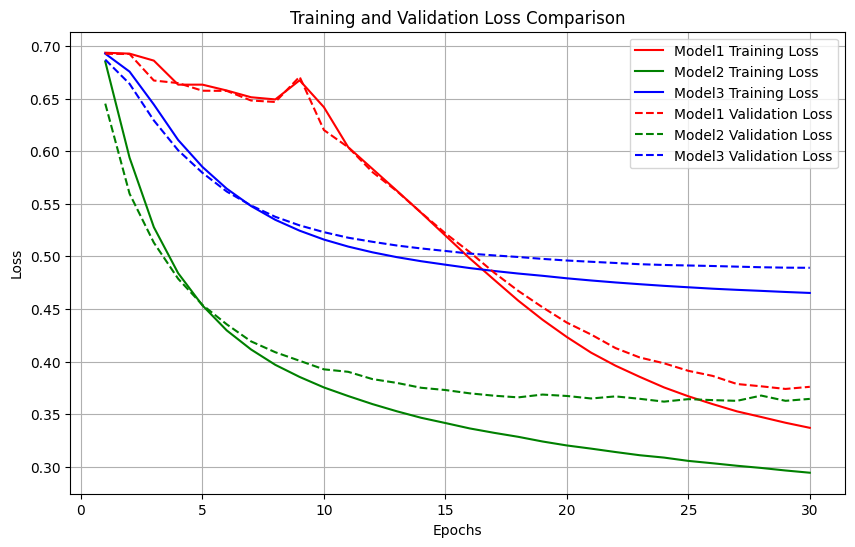

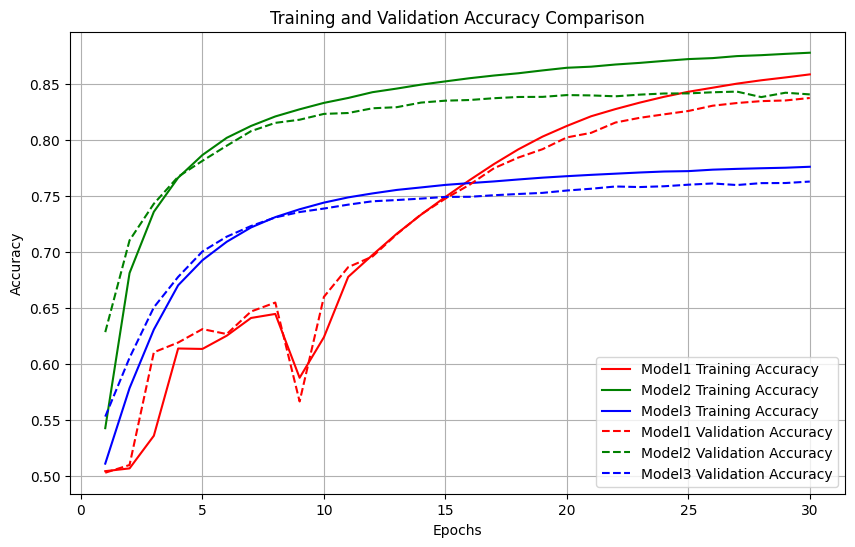

In [64]:
import matplotlib.pyplot as plt

# 모델별 결과 변수
# (이전에 반환받은 변수를 그대로 사용)
# train_losses1, val_losses1, train_accs1, val_accs1
# train_losses2, val_losses2, train_accs2, val_accs2
# train_losses3, val_losses3, train_accs3, val_accs3

epochs_range = range(1, 31)  # epochs=30이면 이렇게 (혹은 len(train_losses1))

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses1, 'r-', label='Model1 Training Loss')
plt.plot(epochs_range, train_losses2, 'g-', label='Model2 Training Loss')
plt.plot(epochs_range, train_losses3, 'b-', label='Model3 Training Loss')
plt.plot(epochs_range, val_losses1, 'r--', label='Model1 Validation Loss')
plt.plot(epochs_range, val_losses2, 'g--', label='Model2 Validation Loss')
plt.plot(epochs_range, val_losses3, 'b--', label='Model3 Validation Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Accuracy 그래프
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_accs1, 'r-', label='Model1 Training Accuracy')
plt.plot(epochs_range, train_accs2, 'g-', label='Model2 Training Accuracy')
plt.plot(epochs_range, train_accs3, 'b-', label='Model3 Training Accuracy')
plt.plot(epochs_range, val_accs1, 'r--', label='Model1 Validation Accuracy')
plt.plot(epochs_range, val_accs2, 'g--', label='Model2 Validation Accuracy')
plt.plot(epochs_range, val_accs3, 'b--', label='Model3 Validation Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


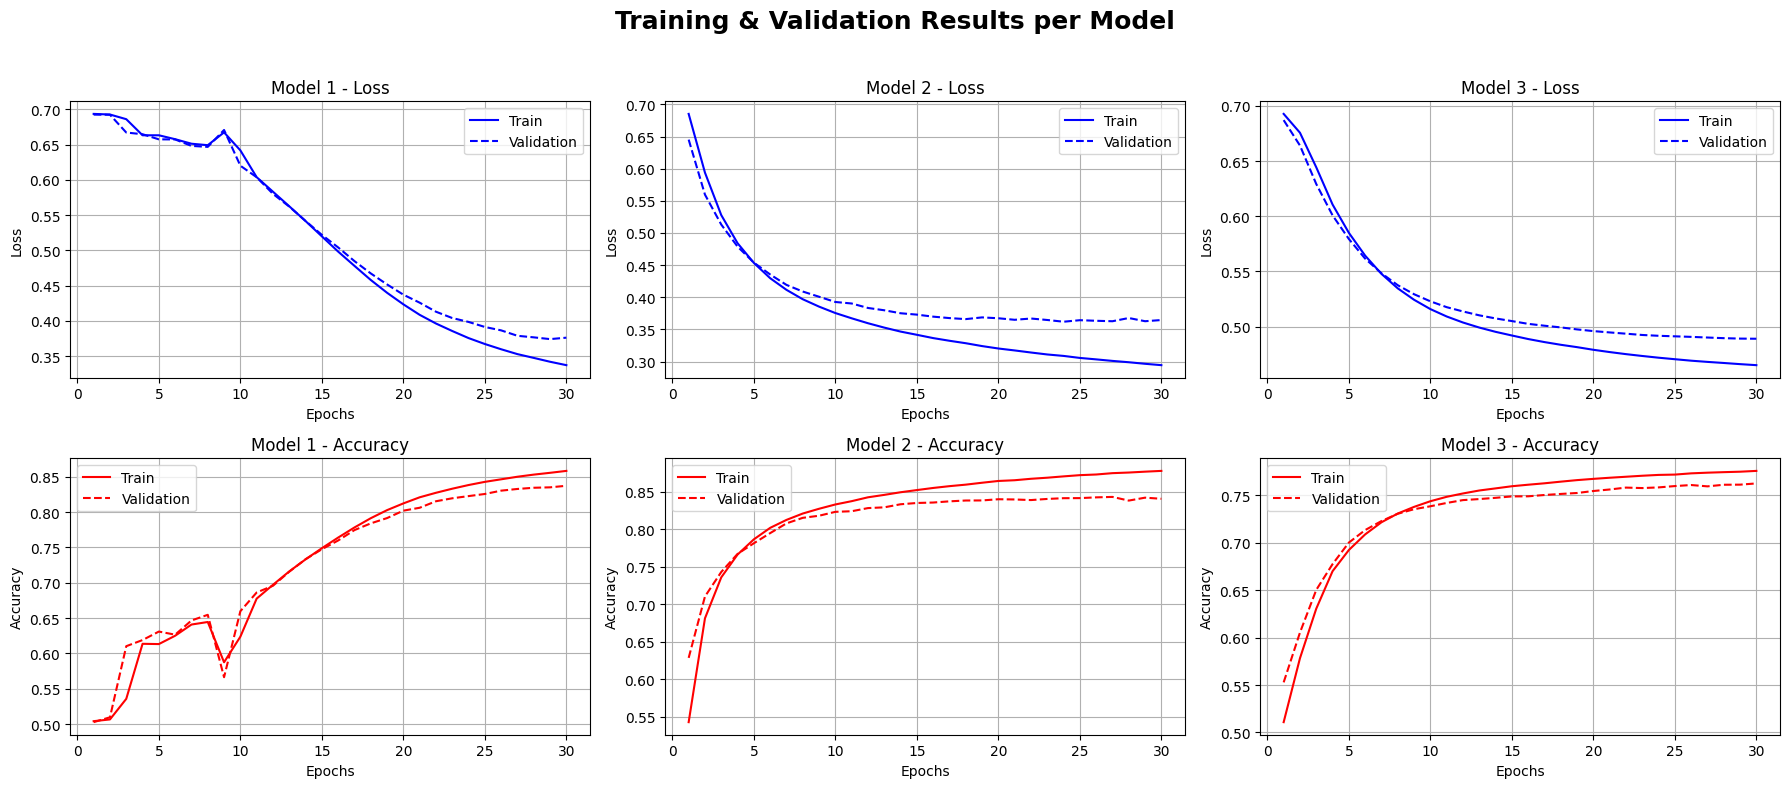

In [67]:
import matplotlib.pyplot as plt

epochs_range = range(1, 31)  # epochs=30 기준

# 2행 × 3열 그래프
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle('Training & Validation Results per Model', fontsize=18, fontweight='bold')

# =========================
# 1행: Loss (Train + Validation)
# =========================
axes[0, 0].plot(epochs_range, train_losses1, 'b-', label='Train')
axes[0, 0].plot(epochs_range, val_losses1, 'b--', label='Validation')
axes[0, 0].set_title('Model 1 - Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(epochs_range, train_losses2, 'b-', label='Train')
axes[0, 1].plot(epochs_range, val_losses2, 'b--', label='Validation')
axes[0, 1].set_title('Model 2 - Loss')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[0, 2].plot(epochs_range, train_losses3, 'b-', label='Train')
axes[0, 2].plot(epochs_range, val_losses3, 'b--', label='Validation')
axes[0, 2].set_title('Model 3 - Loss')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True)

# =========================
# 2행: Accuracy (Train + Validation)
# =========================
axes[1, 0].plot(epochs_range, train_accs1, 'r-', label='Train')
axes[1, 0].plot(epochs_range, val_accs1, 'r--', label='Validation')
axes[1, 0].set_title('Model 1 - Accuracy')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(epochs_range, train_accs2, 'r-', label='Train')
axes[1, 1].plot(epochs_range, val_accs2, 'r--', label='Validation')
axes[1, 1].set_title('Model 2 - Accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

axes[1, 2].plot(epochs_range, train_accs3, 'r-', label='Train')
axes[1, 2].plot(epochs_range, val_accs3, 'r--', label='Validation')
axes[1, 2].set_title('Model 3 - Accuracy')
axes[1, 2].set_xlabel('Epochs')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


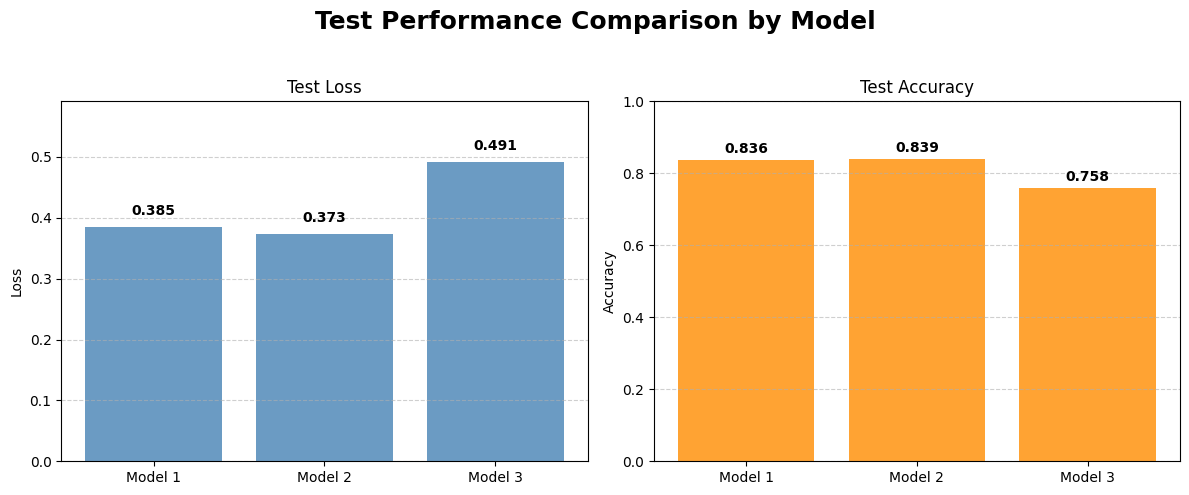

In [68]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Model 1', 'Model 2', 'Model 3']
test_losses = [test_loss1, test_loss2, test_loss3]
test_accs   = [test_acc1,  test_acc2,  test_acc3]

x = np.arange(len(models))
width = 0.6

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Test Performance Comparison by Model', fontsize=18, fontweight='bold')

# ------------------------------
# (1) Test Loss 비교
# ------------------------------
axes[0].bar(models, test_losses, color='steelblue', alpha=0.8)
axes[0].set_title('Test Loss')
axes[0].set_ylabel('Loss')
axes[0].set_ylim(0, max(test_losses) + 0.1)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# 막대 위 값 표시
for i, v in enumerate(test_losses):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

# ------------------------------
# (2) Test Accuracy 비교
# ------------------------------
axes[1].bar(models, test_accs, color='darkorange', alpha=0.8)
axes[1].set_title('Test Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1.0)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# 막대 위 값 표시
for i, v in enumerate(test_accs):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 학습된 Embadding 레이어 분석

In [78]:
# === New Cell: Word2Vec 적용 모델 생성 ===
import numpy as np
import torch
import torch.nn as nn
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 1) Word2Vec 로딩
word2vec_file_path = "./work/sentiment_classification/data/word2vec_ko.model"
w2v = Word2VecKeyedVectors.load(word2vec_file_path)
embed_dim = w2v.wv.vector_size

# 2) vocab 기반 임베딩 매트릭스 구성
PAD_IDX = word_to_index['<PAD>']
vocab_size = len(word_to_index)

embedding_matrix = np.random.normal(0.0, 0.01, size=(vocab_size, embed_dim)).astype(np.float32)
embedding_matrix[PAD_IDX] = 0.0

for token, idx in word_to_index.items():
    if token in w2v.wv.key_to_index:
        embedding_matrix[idx] = w2v.wv[token]

# 3) 기존 모델 구조를 그대로 활용하되 이름만 변경
model1_w2v = Model_1(vocab_size, embed_dim)
model2_w2v = Model_2(vocab_size, embed_dim)
model3_w2v = Model_3(vocab_size, embed_dim)

# 4) 각 모델의 임베딩 레이어에 Word2Vec 가중치 복사
for m in [model1_w2v, model2_w2v, model3_w2v]:
    with torch.no_grad():
        m.embedding.weight.copy_(torch.from_numpy(embedding_matrix))
        m.embedding.weight[PAD_IDX] = 0.0
    m.embedding.weight.requires_grad = True  # 미세튜닝 가능하게 설정

In [71]:
# === New Cell: gensim 유사단어로 자체학습 vs 사전학습 임베딩 비교 ===
import numpy as np
import torch
import torch.nn as nn
from gensim.models.keyedvectors import Word2VecKeyedVectors, KeyedVectors

# ------------------------------------------------------------
# 0) 준비: vocab, index<->token 매핑, 특수토큰, 비교 대상 모델 선택
# ------------------------------------------------------------
PAD = '<PAD>'
SPECIAL_TOKENS = {PAD, '<UNK>', '<BOS>', ''}

# word_to_index 로부터 index_to_word 리스트 만들기
vocab_size = len(word_to_index)
index_to_word = [''] * vocab_size
for w, i in word_to_index.items():
    index_to_word[i] = w

PAD_IDX = word_to_index.get(PAD, 0)

# 비교할 두 모델 지정 (원하면 다른 모델로 바꿔도 됨)
model_self  = model1         # 자체학습 임베딩(랜덤 초기화 후 학습)
model_w2v   = model1_w2v     # 사전학습 Word2Vec 주입/미세튜닝 모델

# ------------------------------------------------------------
# 1) 사전학습 한국어 Word2Vec 로드 (.load -> .wv 사용)
# ------------------------------------------------------------
word2vec_path = "./work/sentiment_classification/data/word2vec_ko.model"
ko_w2v = Word2VecKeyedVectors.load(word2vec_path)  # 주의: load()
w2v_dim = ko_w2v.wv.vector_size
print(f"[INFO] Loaded Ko Word2Vec: dim={w2v_dim}, vocab={len(ko_w2v.wv.key_to_index):,}")

# ------------------------------------------------------------
# 2) PyTorch 임베딩 -> gensim KeyedVectors로 변환 유틸
# ------------------------------------------------------------
def torch_embedding_to_keyedvectors(embedding: nn.Embedding,
                                    idx2word: list[str],
                                    exclude_tokens: set[str] = SPECIAL_TOKENS) -> KeyedVectors:
    """
    torch.nn.Embedding 가중치를 gensim KeyedVectors로 옮겨
    gensim의 most_similar 등을 그대로 쓸 수 있게 변환.
    """
    emb = embedding.weight.detach().cpu().numpy().astype(np.float32)

    # 제외 토큰 제거 및 키/벡터 준비
    keys = []
    vecs = []
    for i, tok in enumerate(idx2word):
        if tok in exclude_tokens:
            continue
        keys.append(tok)
        vecs.append(emb[i])

    kv = KeyedVectors(vector_size=emb.shape[1])
    kv.add_vectors(keys, np.stack(vecs, axis=0))
    return kv

# 모델에서 embedding 레이어 찾아오는 헬퍼 (속성명이 다를 수도 있음)
def get_embedding_layer(m: nn.Module) -> nn.Embedding:
    # 관례적으로 .embedding 또는 .embed 등 사용—필요시 수정
    for name, module in m.named_modules():
        if isinstance(module, nn.Embedding):
            return module
    raise ValueError("nn.Embedding 레이어를 모델에서 찾지 못했습니다. 속성명을 확인하세요.")

# ------------------------------------------------------------
# 3) 자체학습 / Word2Vec-초기 모델 임베딩을 KeyedVectors로 변환
# ------------------------------------------------------------
kv_self  = torch_embedding_to_keyedvectors(get_embedding_layer(model_self),  index_to_word)
kv_w2vin = torch_embedding_to_keyedvectors(get_embedding_layer(model_w2v),   index_to_word)

# ------------------------------------------------------------
# 4) 비교 함수: 유사단어, 겹침 비율(Overlap@K), 코사인 유사도 비교
# ------------------------------------------------------------
from typing import List, Tuple

def safe_most_similar(kv: KeyedVectors, word: str, topn: int = 10) -> List[Tuple[str, float]]:
    try:
        return kv.most_similar(positive=[word], topn=topn)
    except KeyError:
        return []

def overlap_at_k(list_a: List[str], list_b: List[str], k: int = 10) -> float:
    a = set(list_a[:k])
    b = set(list_b[:k])
    if not a and not b:
        return 0.0
    return len(a & b) / float(k)

def analyze_word(word: str, topn: int = 10):
    # 4-1) 세 공간에서 유사어
    sim_self   = safe_most_similar(kv_self,  word, topn=topn)
    sim_w2vin  = safe_most_similar(kv_w2vin, word, topn=topn)
    sim_ko_w2v = safe_most_similar(ko_w2v.wv, word, topn=topn)  # 주의: .wv 사용

    # 4-2) top-k 토큰만 추출
    self_words   = [w for w, _ in sim_self]
    w2vin_words  = [w for w, _ in sim_w2vin]
    ko_w2v_words = [w for w, _ in sim_ko_w2v]

    # 4-3) Overlap@K (자체 vs KoW2V, W2V-initial vs KoW2V, 자체 vs W2V-initial)
    ov_self_vs_ko   = overlap_at_k(self_words,   ko_w2v_words, k=topn)
    ov_w2vin_vs_ko  = overlap_at_k(w2vin_words,  ko_w2v_words, k=topn)
    ov_self_vs_w2vi = overlap_at_k(self_words,   w2vin_words,  k=topn)

    # 4-4) 출력
    print("="*80)
    print(f"[TARGET] '{word}'  (top{topn})")
    def pretty(name, pairs):
        if not pairs:
            print(f"  - {name}: OOV or no neighbors.")
        else:
            left = [f"{w}({s:.2f})" for w,s in pairs]
            print(f"  - {name}: " + ", ".join(left))

    pretty("Self-trained",    sim_self)
    pretty("W2V-initialized", sim_w2vin)
    pretty("Ko-Word2Vec",     sim_ko_w2v)

    print("  · Overlap@{k}  (Self vs KoW2V):       {:.2f}".format(ov_self_vs_ko,   k=topn))
    print("  · Overlap@{k}  (W2V-initial vs KoW2V): {:.2f}".format(ov_w2vin_vs_ko,  k=topn))
    print("  · Overlap@{k}  (Self vs W2V-initial):  {:.2f}".format(ov_self_vs_w2vi, k=topn))

# ------------------------------------------------------------
# 5) 분석 실행: 비교할 단어 목록 지정 (코퍼스에 존재하는 단어로!)
#    ※ vocab에 없는 단어는 자동으로 건너뜀
# ------------------------------------------------------------
probe_words = [
    "끝", "사랑", "영화", "배우", "재미", "음악", "학교", "컴퓨터", "한국", "행복"
]

for w in probe_words:
    # vocab에 없으면 스킵 알림
    if w not in word_to_index and w not in ko_w2v.wv.key_to_index:
        continue
    analyze_word(w, topn=10)

# ------------------------------------------------------------
# 6) (선택) 전체적 경향 요약: 평균 Overlap@10를 간단 집계
# ------------------------------------------------------------
def avg_overlap(words):
    count = 0
    sum_self_vs_ko = 0.0
    sum_w2vi_vs_ko = 0.0
    sum_self_vs_w2 = 0.0
    for w in words:
        sim_self   = safe_most_similar(kv_self,  w, 10)
        sim_w2vin  = safe_most_similar(kv_w2vin, w, 10)
        sim_ko_w2v = safe_most_similar(ko_w2v.wv, w, 10)
        if not sim_self or not sim_w2vin or not sim_ko_w2v:
            continue
        self_words   = [x for x,_ in sim_self]
        w2vin_words  = [x for x,_ in sim_w2vin]
        ko_w2v_words = [x for x,_ in sim_ko_w2v]
        sum_self_vs_ko += overlap_at_k(self_words,   ko_w2v_words, 10)
        sum_w2vi_vs_ko += overlap_at_k(w2vin_words,  ko_w2v_words, 10)
        sum_self_vs_w2 += overlap_at_k(self_words,   w2vin_words,  10)
        count += 1
    if count == 0:
        return (0.0, 0.0, 0.0, 0)
    return (sum_self_vs_ko/count, sum_w2vi_vs_ko/count, sum_self_vs_w2/count, count)

avg_self_vs_ko, avg_w2vi_vs_ko, avg_self_vs_w2, used = avg_overlap(probe_words)
print("\n" + "-"*80)
print(f"[SUMMARY] 평균 Overlap@10 (표본 {used}개 기준)")
print("  · Self vs Ko-Word2Vec      : {:.2f}".format(avg_self_vs_ko))
print("  · W2V-initial vs Ko-Word2Vec: {:.2f}".format(avg_w2vi_vs_ko))
print("  · Self vs W2V-initial       : {:.2f}".format(avg_self_vs_w2))

[INFO] Loaded Ko Word2Vec: dim=100, vocab=302,960
[TARGET] '끝'  (top10)
  - Self-trained: 경상도(1.00), 나사(1.00), 엑(1.00), --;;(1.00), 에리카(0.99), 호호(0.99), 빌리(0.99), 화가(0.99), 땜시(0.99), 풍부(0.99)
  - W2V-initialized: 마지막(0.63), 양쪽(0.53), 무릎(0.52), 후(0.51), 중간(0.50), 뒤(0.50), 결국(0.50), 막판(0.49), 앞(0.49), 어깨(0.49)
  - Ko-Word2Vec: 마지막(0.63), 결판(0.55), 발목(0.55), 산산조각(0.54), 막바지(0.54), 싫증(0.53), 양쪽(0.53), 무릎(0.52), 후(0.51), 이어진(0.50)
  · Overlap@10  (Self vs KoW2V):       0.00
  · Overlap@10  (W2V-initial vs KoW2V): 0.40
  · Overlap@10  (Self vs W2V-initial):  0.00
[TARGET] '사랑'  (top10)
  - Self-trained: 류덕환(1.00), 보여준(1.00), 힐링(1.00), 빛났(1.00), 콜라(1.00), 얹(0.99), 알려(0.99), 조아(0.99), 몰랐(0.99), 되돌아보(0.99)
  - W2V-initialized: 이별(0.76), 행복(0.76), 슬픔(0.74), 유혹(0.72), 그리움(0.72), 추억(0.71), 꿈(0.71), 애정(0.71), 마음(0.70), 엄마(0.69)
  - Ko-Word2Vec: 이별(0.76), 행복(0.76), 슬픔(0.74), 유혹(0.72), 그리움(0.72), 추억(0.71), 꿈(0.71), 애정(0.71), 포옹(0.70), 마음(0.70)
  · Overlap@10  (Self vs KoW2V):       0.00
  · Overlap@1

### 한 줄 요약
사전학습 Word2Vec으로 초기화한 모델은 Ko-Word2Vec의 의미 공간을 상당히 유지하고 있지만, 랜덤 초기화 후 자체 학습한 임베딩은 거의 완전히 붕괴된 의미 공간을 보인다.

### 전반적 패턴 요약
| 비교 구분                          | 평균 Overlap@10 | 해석                                                             |
| ------------------------------ | ------------- | -------------------------------------------------------------- |
| **Self vs Ko-Word2Vec**        | **0.00**      | 자체 학습 임베딩은 Ko-Word2Vec과 의미 공간이 완전히 다름. 학습 데이터에서 의미 구조가 형성되지 않음 |
| **W2V-initial vs Ko-Word2Vec** | **0.64**      | 사전학습 임베딩 기반 모델은 Ko-Word2Vec과 상당히 유사한 의미 구조를 유지함                |
| **Self vs W2V-initial**        | **0.00**      | 두 모델의 임베딩이 거의 다른 공간에 위치함. 서로 다른 학습 궤적                          |

W2V-초기화 모델은 여전히 Ko-Word2Vec의 의미 관계를 보존하고 있음 → “이전 지식 유지 + 도메인 적응”

자체 학습 임베딩은 의미 구조를 형성하지 못했거나, 완전히 다른 기준(예: 빈도, 오탈자, 데이터 잡음 등)으로 벡터가 배치됨.

### 단어별 세부 해석
| 단어      | W2V-initial vs KoW2V Overlap | 해석                                                                |
| ------- | ---------------------------- | ----------------------------------------------------------------- |
| **끝**   | 0.40                         | “마지막, 막판, 중간…” 등 의미상 유사. Word2Vec-initial은 의미를 유지했지만 Self는 무관한 단어 |
| **사랑**  | 0.90                         | 거의 완벽히 일치. 감정/정서 관련 의미망이 그대로 유지됨                                  |
| **영화**  | 0.90                         | 영화→드라마·뮤지컬·코미디 등 매우 일관됨                                           |
| **배우**  | 0.40                         | 직업군 관련 유사어 일부 일치 (가수·연기자 등)                                       |
| **재미**  | 0.90                         | 흥미·유머·보람 등 의미망 그대로 유지                                             |
| **음악**  | 0.50                         | 장르 기반 연관어(재즈·팝·힙합 등) 유지, 일부만 다름                                   |
| **학교**  | 0.30                         | 하위기관(고등학교, 중학교 등) 일부 일치                                           |
| **컴퓨터** | 0.10                         | 기술 관련 단어 유지하나 Overlap 낮음 (도메인 차이 때문)                              |
| **한국**  | 1.00                         | 완벽히 일치 (국가명·지역명 구조 유지)                                            |
| **행복**  | 1.00                         | 감정/철학 관련 단어 완벽 일치                                                 |

평균적으로 Ko-Word2Vec과 0.64의 Overlap,
즉, 10개 유사어 중 6~7개 정도가 그대로 겹침.

반면 자체 학습 모델은 모든 단어에서 0.00 — 즉,
Ko-Word2Vec과 완전히 다른 유사어를 반환.
심지어 “사랑 → 류덕환, 힐링, 콜라, 조아…” 등 의미상 무관한 단어가 등장.

### 원인 분석
1. 자체 학습 임베딩이 무의미한 이유

- 학습 데이터의 크기 부족
    
    Word2Vec 수준의 의미 공간을 형성하려면 수억 단어 이상 필요하지만, 자체 학습은 일반적으로 훨씬 작은 텍스트셋(예: 리뷰, 댓글, 자막 등)에 국한.

- 모델 구조상 임베딩이 학습되지 않았거나 손실함수와의 연결이 약함
    
    → 분류나 감정 예측 중심 모델일 경우, 오로지 태스크별 신호만으로 임베딩이 최적화되며, 의미적 구조는 무시됨.

- 학습 초기에 랜덤 초기화
    
    → 학습 데이터가 적을 경우, 임베딩 공간이 안정적으로 수렴하지 않고 각 토큰이 임의의 방향으로 흩어짐.

2. Word2Vec-초기화 모델이 효과적인 이유

- 사전학습된 Ko-Word2Vec 벡터는 언어의 일반적 의미 구조(semantic manifold) 를 이미 내포.
- 파인튜닝 과정에서도 gradient drift 가 완만히 진행되어 “기초 의미 관계”를 유지하면서 도메인 특화 정보만 약간 조정됨.
- 결과적으로 Ko-Word2Vec과 높은 Overlap 을 유지.

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. [참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models), [참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)
```
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv[‘끝’]
```

In [79]:
# === New Cell: Word2Vec 적용 모델 생성 ===
import numpy as np
import torch
import torch.nn as nn
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 1) Word2Vec 로딩
word2vec_file_path = "./work/sentiment_classification/data/word2vec_ko.model"
w2v = Word2VecKeyedVectors.load(word2vec_file_path)
embed_dim = w2v.wv.vector_size

# 2) vocab 기반 임베딩 매트릭스 구성
PAD_IDX = word_to_index['<PAD>']
vocab_size = len(word_to_index)

embedding_matrix = np.random.normal(0.0, 0.01, size=(vocab_size, embed_dim)).astype(np.float32)
embedding_matrix[PAD_IDX] = 0.0

for token, idx in word_to_index.items():
    if token in w2v.wv.key_to_index:
        embedding_matrix[idx] = w2v.wv[token]

# 3) 기존 모델 구조를 그대로 활용하되 이름만 변경
model1_w2v = Model_1(vocab_size, embed_dim)
model2_w2v = Model_2(vocab_size, embed_dim)
model3_w2v = Model_3(vocab_size, embed_dim)

# 4) 각 모델의 임베딩 레이어에 Word2Vec 가중치 복사
for m in [model1_w2v, model2_w2v, model3_w2v]:
    with torch.no_grad():
        m.embedding.weight.copy_(torch.from_numpy(embedding_matrix))
        m.embedding.weight[PAD_IDX] = 0.0
    m.embedding.weight.requires_grad = False  # 미세튜닝 가능하게 설정

In [ ]:
train_losses1_w2v, val_losses1_w2v, train_accs1_w2v, val_accs1_w2v, test_loss1_w2v, test_acc1_w2v = train_and_evaluate_model(
    model1_w2v,
    partial_x_train, partial_y_train,
    x_val, y_val,
    x_test_padded, y_test,
    epochs=30
)

/tmp/ipython-input-1649706543.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipython-input-1649706543.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


Epoch 1/30 - Train Loss: 0.6934, Train Acc: 0.5061 - Val Loss: 0.6921, Val Acc: 0.5076
Epoch 2/30 - Train Loss: 0.6608, Train Acc: 0.6243 - Val Loss: 0.6495, Val Acc: 0.6453
Epoch 3/30 - Train Loss: 0.6455, Train Acc: 0.6476 - Val Loss: 0.6405, Val Acc: 0.6501
Epoch 4/30 - Train Loss: 0.6354, Train Acc: 0.6631 - Val Loss: 0.6338, Val Acc: 0.6593
Epoch 5/30 - Train Loss: 0.6320, Train Acc: 0.6679 - Val Loss: 0.6328, Val Acc: 0.6694
Epoch 6/30 - Train Loss: 0.6241, Train Acc: 0.6744 - Val Loss: 0.6249, Val Acc: 0.6573
Epoch 7/30 - Train Loss: 0.6184, Train Acc: 0.6795 - Val Loss: 0.6127, Val Acc: 0.6798
Epoch 8/30 - Train Loss: 0.6071, Train Acc: 0.6917 - Val Loss: 0.6124, Val Acc: 0.6893
Epoch 9/30 - Train Loss: 0.5988, Train Acc: 0.6986 - Val Loss: 0.6028, Val Acc: 0.6890
Epoch 10/30 - Train Loss: 0.5876, Train Acc: 0.7072 - Val Loss: 0.5884, Val Acc: 0.7051
Epoch 11/30 - Train Loss: 0.5699, Train Acc: 0.7197 - Val Loss: 0.5642, Val Acc: 0.7197
Epoch 12/30 - Train Loss: 0.5464, Train A

In [ ]:
train_losses2_w2v, val_losses2_w2v, train_accs2_w2v, val_accs2_w2v, test_loss2_w2v, test_acc2_w2v = train_and_evaluate_model(
    model2_w2v,
    partial_x_train, partial_y_train,
    x_val, y_val,
    x_test_padded, y_test,
    epochs=30
)

In [ ]:
train_losses3_w2v, val_losses3_w2v, train_accs3_w2v, val_accs3_w2v, test_loss3_w2v, test_acc3_w2v = train_and_evaluate_model(
    model3_w2v,
    partial_x_train, partial_y_train,
    x_val, y_val,
    x_test_padded, y_test,
    epochs=30
)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses1_w2v, 'r-', label='Model1_w2v Train')
plt.plot(epochs_range, train_losses2_w2v, 'g-', label='Model2_w2v Train')
plt.plot(epochs_range, train_losses3_w2v, 'b-', label='Model3_w2v Train')
plt.plot(epochs_range, val_losses1_w2v, 'r--', label='Model1_w2v Val')
plt.plot(epochs_range, val_losses2_w2v, 'g--', label='Model2_w2v Val')
plt.plot(epochs_range, val_losses3_w2v, 'b--', label='Model3_w2v Val')
plt.title('Training & Validation Loss Comparison (Word2Vec Models)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_accs1_w2v, 'r-', label='Model1_w2v Train')
plt.plot(epochs_range, train_accs2_w2v, 'g-', label='Model2_w2v Train')
plt.plot(epochs_range, train_accs3_w2v, 'b-', label='Model3_w2v Train')
plt.plot(epochs_range, val_accs1_w2v, 'r--', label='Model1_w2v Val')
plt.plot(epochs_range, val_accs2_w2v, 'g--', label='Model2_w2v Val')
plt.plot(epochs_range, val_accs3_w2v, 'b--', label='Model3_w2v Val')
plt.title('Training & Validation Accuracy Comparison (Word2Vec Models)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle('Training & Validation Results per Word2Vec Model', fontsize=18, fontweight='bold')

# 1행: Loss
axes[0, 0].plot(epochs_range, train_losses1_w2v, 'b-', label='Train')
axes[0, 0].plot(epochs_range, val_losses1_w2v, 'b--', label='Validation')
axes[0, 0].set_title('Model 1_w2v - Loss')
axes[0, 0].legend(); axes[0, 0].grid(True)

axes[0, 1].plot(epochs_range, train_losses2_w2v, 'b-', label='Train')
axes[0, 1].plot(epochs_range, val_losses2_w2v, 'b--', label='Validation')
axes[0, 1].set_title('Model 2_w2v - Loss')
axes[0, 1].legend(); axes[0, 1].grid(True)

axes[0, 2].plot(epochs_range, train_losses3_w2v, 'b-', label='Train')
axes[0, 2].plot(epochs_range, val_losses3_w2v, 'b--', label='Validation')
axes[0, 2].set_title('Model 3_w2v - Loss')
axes[0, 2].legend(); axes[0, 2].grid(True)

# 2행: Accuracy
axes[1, 0].plot(epochs_range, train_accs1_w2v, 'r-', label='Train')
axes[1, 0].plot(epochs_range, val_accs1_w2v, 'r--', label='Validation')
axes[1, 0].set_title('Model 1_w2v - Accuracy')
axes[1, 0].legend(); axes[1, 0].grid(True)

axes[1, 1].plot(epochs_range, train_accs2_w2v, 'r-', label='Train')
axes[1, 1].plot(epochs_range, val_accs2_w2v, 'r--', label='Validation')
axes[1, 1].set_title('Model 2_w2v - Accuracy')
axes[1, 1].legend(); axes[1, 1].grid(True)

axes[1, 2].plot(epochs_range, train_accs3_w2v, 'r-', label='Train')
axes[1, 2].plot(epochs_range, val_accs3_w2v, 'r--', label='Validation')
axes[1, 2].set_title('Model 3_w2v - Accuracy')
axes[1, 2].legend(); axes[1, 2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
models = ['Model 1_w2v', 'Model 2_w2v', 'Model 3_w2v']
test_losses = [test_loss1_w2v, test_loss2_w2v, test_loss3_w2v]
test_accs   = [test_acc1_w2v,  test_acc2_w2v,  test_acc3_w2v]

x = np.arange(len(models))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Word2Vec Model Test Performance', fontsize=18, fontweight='bold')

# (1) Test Loss
axes[0].bar(models, test_losses, color='steelblue', alpha=0.8)
axes[0].set_title('Test Loss')
axes[0].set_ylabel('Loss')
axes[0].set_ylim(0, max(test_losses) + 0.1)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(test_losses):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

# (2) Test Accuracy
axes[1].bar(models, test_accs, color='darkorange', alpha=0.8)
axes[1].set_title('Test Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1.0)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)
for i, v in enumerate(test_accs):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 회고
- 직접 구현한 모델과 사전 학습한 모델의 성능 차이가 크다는 것을 눈으로 직접 확인할 수 있었다.
- padding을 뒤에 추가하여 구현했는데 성능 향상을 위해 앞에 추가하는 방식을 시도하면 좋았을 것 같다.